In [19]:
import scienceplots
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pgf import FigureCanvasPgf

matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)


# use fancy style and tex in plt
plt.style.use(['science', 'russian-font'])
matplotlib.rc('text', usetex = True)
preamble = plt.rcParams.get('text.latex.preamble')
params = {
  'pgf.rcfonts' : False,
  'pgf.texsystem' : 'pdflatex',
  'pgf.preamble' : "\n".join([preamble,r'\usepackage{textcomp,mathcomp}'])

}
plt.rcParams.update(params)
plt.rcParams.update({"axes.grid" : True, "grid.linestyle" : (0, (5, 10))})

In [20]:
import os
current_dir = os.getcwd().lower()

output_dir = 'processor_output'
# Create output folder if it does not exist
if (not os.path.exists(f'./{output_dir}')):
    os.makedirs(output_dir)

In [21]:
df = pd.read_csv('data.csv')
df.head()

,measurement_number,temperature,frequency
0,1,23.5,448
1,2,23.5,660
2,3,23.5,874
3,4,23.5,1088
4,5,23.5,1306


In [22]:
measurements_table = df.pivot_table(values='frequency',
                                    index='measurement_number',
                                    columns='temperature').astype('int')

temperatures = measurements_table.columns \
          .to_series(name='temperature') \
          .astype('str') \
          .replace(to_replace = "\.0+$",value = "", regex = True) \
          .to_csv(f'{output_dir}/temperatures.csv', index=False)
new_cols = [x for col in measurements_table.columns \
            for x in (col, str(col)+"shifted")]
for col in measurements_table.columns:
  col_mnts = measurements_table[col]
  measurements_table[str(col)+"shifted"] = col_mnts - col_mnts.min()

measurements_table = measurements_table[new_cols]
measurements_table.to_csv(f'{output_dir}/measurements_table.csv')
measurements_table

temperature,23.5,23.5shifted,35.0,35.0shifted,43.0,43.0shifted,49.0,49.0shifted,57.0,57.0shifted
measurement_number,,,,,,,,,,
1,448,0,456,0,462,0,466,0,472,0
2,660,212,671,215,679,217,687,221,694,222
3,874,426,890,434,899,437,908,442,920,448
4,1088,640,1109,653,1121,659,1134,668,1146,674
5,1306,858,1330,874,1345,883,1359,893,1376,904
6,1522,1074,1550,1094,1568,1106,1584,1118,1604,1132
7,1738,1290,1771,1315,1791,1329,1810,1344,1831,1359
8,1954,1506,1989,1533,2014,1552,2034,1568,2058,1586
9,2170,1722,2210,1754,2238,1776,2259,1793,2286,1814


In [23]:
# subtract minimum frequency for each series of measurements
df.frequency = df.groupby('temperature')['frequency'] \
                .transform(lambda x: x - min(x))
# measurements in 0-indexation
df.measurement_number = df.measurement_number - 1

#### Constants

In [24]:
# length of the tube (m)
LENGTH = 0.8
LENGTH_ERROR = 0.001
# gas constant
R = 8.31
# 0 celsium in kelvin
TRIPLE_POINT = 273.16
# molar mass of air (g/mol)
MU = 0.029
# thermostat temperature error
TEMP_ERROR = 0.02

In [25]:
def calculate_min_max_slope(x: pd.Series, y: pd.Series,
                            y_error: pd.Series, fit_intercept=True) -> tuple[int, int]:
  """
    Calcucate slope's error
  """

  if fit_intercept:
    pivot = x.mean()
  else:
    pivot = 0
  lm = LinearRegression(fit_intercept=fit_intercept)
  y_pos = y + y_error
  y_neg = y - y_error

  # max slope
  y = y_pos.copy()
  y[x < pivot] = y_neg[x < pivot]
  lm.fit(np.array(x).reshape(-1, 1), y)
  max_slope = lm.coef_[0]

  # min slope
  y = y_neg.copy()
  y[x < pivot] = y_pos[x < pivot]
  lm.fit(np.array(x).reshape(-1, 1), y)
  min_slope = lm.coef_[0]
  return (min_slope, max_slope)

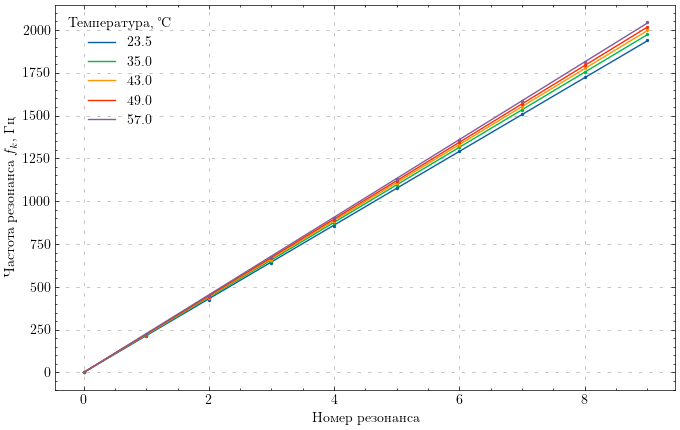

In [26]:
def plot_scatter_trendline(x, y, label, fit_intercept=True):
  """
  Plot frequency depending on measurement index
  """
  lm = LinearRegression(fit_intercept=fit_intercept)
  lm.fit(np.array(x).reshape(-1, 1), y)

  x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
  y_pred = lm.predict(x_pred)

  plt.scatter(x, y, s=2, zorder=10)
  plt.plot(x_pred, y_pred, label=label)
  return lm

speed_of_sound = []

plt.figure(figsize=(8, 5))
for temperature in df.temperature.unique():
  x = df[df.temperature == temperature].measurement_number
  y = df[df.temperature == temperature].frequency
  lm = plot_scatter_trendline(x, y, label=str(temperature), fit_intercept=False)

  error = y.copy()
  error = 2
  # calculating speed of sound error (min value and max value)
  min_slope, max_slope = calculate_min_max_slope(x, y, error, fit_intercept=False)
  speed_of_sound.append({
    'temperature': temperature,
    'speed_of_sound': 2 * LENGTH * lm.coef_[0],
    'low_bar': 2 * (LENGTH - LENGTH_ERROR) * min_slope,
    'high_bar': 2 * (LENGTH + LENGTH_ERROR) * max_slope
  })

speed_of_sound_df = pd.DataFrame(speed_of_sound).set_index('temperature')

plt.legend(title="Температура" + r", \textcelsius")
plt.xlabel('Номер резонанса')
plt.ylabel(r'Частота резонанса $f_k$, Гц')
plt.savefig(f'{output_dir}/frequencies.pgf')
plt.show()

In [27]:
speed_of_sound_df

,speed_of_sound,low_bar,high_bar
temperature,,,
23.5,344.112281,343.177509,345.048316
35.0,350.517895,349.575116,351.461937
43.0,354.672281,353.724309,355.621516
49.0,358.321404,357.368870,359.275200
57.0,362.503860,361.546098,363.462884


0


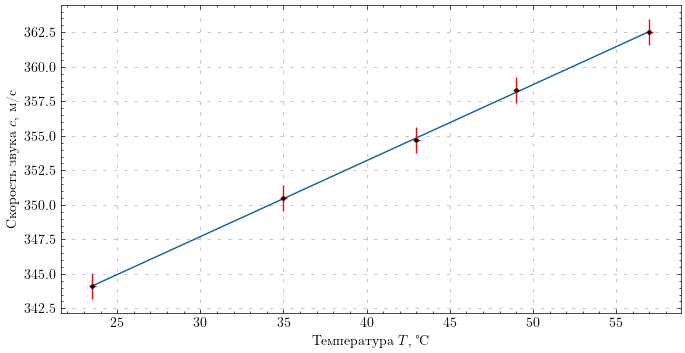

In [28]:
def plot_speed_of_sound(df):
  """
  Plot speed of sound depending on temperature
  """
  x = df.temperature
  y = df.speed_of_sound
  yerr = pd.concat([y - df.low_bar, df.high_bar - y], axis=1)

  lm = LinearRegression()
  print(0)
  lm.fit(np.array(x).reshape(-1, 1), y)

  x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
  y_pred = lm.predict(x_pred)

  plt.plot(x_pred, y_pred)
  plt.errorbar(x, y, yerr=yerr.transpose(), xerr=0.2, ls='None', ecolor='red')
  plt.scatter(x, y, s=5, c='black', zorder=10)
  return lm


plt.figure(figsize=(8, 4))
speed_of_sound_estimator = plot_speed_of_sound(speed_of_sound_df.reset_index())

plt.xlabel(r'Температура $T$, \textcelsius')
plt.ylabel(r'Скорость звука $c$, м/c')
plt.savefig(f'{output_dir}/speed_of_sound.pgf')
plt.show()

In [29]:
# Output latex-formatted table (speed_of_sound.csv)
speed_of_sound_df["mean_error"] = \
  (speed_of_sound_df.high_bar - speed_of_sound_df.low_bar) / 2
speed_of_sound_df_out = speed_of_sound_df.copy() \
      .reset_index() \
      .drop(columns=['low_bar', 'high_bar']) \
      .round(2) \
      .astype(str) \
      .replace(to_replace = "\.0+$",value = "", regex = True) \
      .set_index('temperature')
speed_of_sound_df_out =  ("{" + speed_of_sound_df_out.speed_of_sound +
    r" $\pm$ " + speed_of_sound_df_out.mean_error + "}").to_frame().transpose()

speed_of_sound_df_out.to_csv(f"{output_dir}/speed_of_sound.csv")
speed_of_sound_df_out

temperature,23.5,35,43,49,57
0,{344.11 $\pm$ 0.94},{350.52 $\pm$ 0.94},{354.67 $\pm$ 0.95},{358.32 $\pm$ 0.95},{362.5 $\pm$ 0.96}


Погрешность скорости звука:

In [30]:
speed_of_sound_df.mean_error.agg(['mean', 'std'])

mean    0.947795
std     0.008868
Name: mean_error, dtype: float64

In [31]:
c = speed_of_sound_estimator.predict(np.array([[20]]))[0]
print('At 20 degrees celsium:')
print(c)
print('Difference with real (343.1 celsium):')
print(343.1 - c)
print("Error:")
print((343.1 - c) / 343.1)

At 20 degrees celsium:
342.1975887086136
Difference with real (343.1 celsium):
0.9024112913864428
Error:
0.002630169896200649


Показатель адиабаты:
$$ \gamma = \frac{\mu}{RT}c^2 $$

In [32]:
# calculate isentropic expansion factor
temperature = speed_of_sound_df.index.to_series()
speed_of_sound = speed_of_sound_df.speed_of_sound
gamma = MU * speed_of_sound ** 2 / (R * (temperature + TRIPLE_POINT))

gamma.name = 'gamma'
gamma = pd.concat([gamma, temperature], axis=1).set_index('temperature')
gamma

,gamma
temperature,
23.5,1.392959
35.0,1.391365
43.0,1.388496
49.0,1.390820
57.0,1.388986


In [33]:
# output gamma to gamma.csv
gamma_out = gamma.round(3).reset_index()\
    .astype(str) \
    .replace(to_replace = "\.0+$",value = "", regex = True) \
    .set_index('temperature').T
gamma_out['mean'] = gamma.mean()
gamma_out['std'] = gamma.std()
gamma_out = gamma_out.round(3)
gamma_out.to_csv(f'{output_dir}/gamma.csv')
gamma_out

temperature,23.5,35,43,49,57,mean,std
gamma,1.393,1.391,1.388,1.391,1.389,1.391,0.002


Погрешность показателя адиабаты:

In [34]:
temp_eps = TEMP_ERROR / TRIPLE_POINT
speed_of_sound_eps = speed_of_sound_df.mean_error.mean() / 343.1
gamma_eps = (1 + speed_of_sound_eps) ** 2 / (1 - temp_eps) - 1
gamma_eps * gamma.mean().values[0]

0.007795491989252491

In [35]:
# statistical error and mean
gamma.agg(['mean', 'std'])

,gamma
mean,1.390525
std,0.001817


$$ \gamma = 1.391 \pm 0.01$$